In [1]:
!pip install irbasis

    100% |████████████████████████████████| 7.8MB 3.8MB/s 


In [0]:
import numpy
import irbasis
import scipy
import scipy.integrate as integrate
import matplotlib
import matplotlib.pyplot as plt

In [0]:
# Load fermionic IR basis
Lambda = 100.0
wmax = 1
beta = Lambda / wmax

#basis = irbasis.load('F', Lambda, 'irbasis.h5')
basis = irbasis.load('F', Lambda)
dim = basis.dim()

# Computing $\rho_l$

Here we compute expansion coefficients of a model spectrum using
$$
\rho_l = \int^{\omega_{{\rm max}}}_{-{\omega_{{\rm max}}}}d\omega \rho(\omega)V_l(\omega)
$$
$$
V_l(\omega) = \sqrt{\frac{1}{\omega_{{\rm max}}} }v_l(y / \omega_{{\rm max}})
$$

We consider two typical cases: a semicircular DOS (metal) and a DOS consisting of two peaks (insulator).
The definitions are the following:
$$
\rho_\mathrm{Metal}(\omega) = \frac{2}{\pi
}\sqrt{1-\omega^2}
$$
$$
\rho_\mathrm{Insulator}(\omega) = \frac{1}{2}(\delta(\omega-1) + \delta(\omega+1)) 
$$

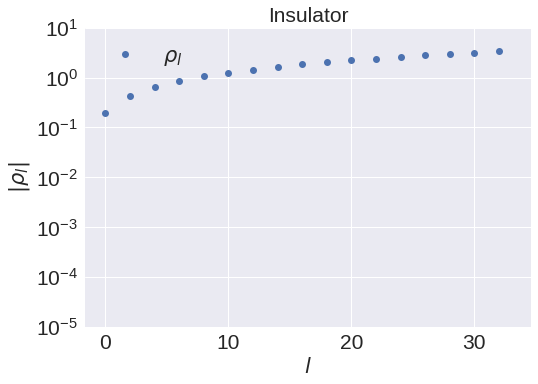

In [4]:
#model = "Metal"
model = "Insulator"  #Pole at \omega = -1,+1


rho_l = numpy.empty(dim)
if model == "Metal":
    rho = lambda omega: (2/numpy.pi) * numpy.sqrt(1-omega**2)
    for l in range(dim):
        rho_l[l] = scipy.integrate.quad(
            lambda omega: rho(omega)*numpy.sqrt(1/wmax)*basis.vly(l,omega/wmax),
            -wmax, wmax,limit = 500)[0]
else:
    pole = 1
    for l in range(dim):
        rho_l[l] = 0.5 * numpy.sqrt(1/wmax)* (basis.vly(l,pole/wmax) + basis.vly(l,-pole/wmax))

plt.ylim([1e-5,10])
plt.semilogy(numpy.abs(rho_l), marker="o", ls='', label=r"$\rho_l$")
plt.title(model, fontsize = 21)
plt.tick_params(labelsize=21)
plt.ylabel(r"$|\rho_l|$", fontsize = 21)
plt.xlabel(r'$l$', fontsize = 21)
plt.legend(frameon=False, fontsize = 21)

# Computing $G_l$ from $\rho_l$
We compute expansion coeffcients of $G(\tau)$ using
$$
G_l = -S_l \rho_l
$$
$$
S_l = \sqrt{\frac{\beta\omega_{{\rm max}}}{2} }s_l.
$$


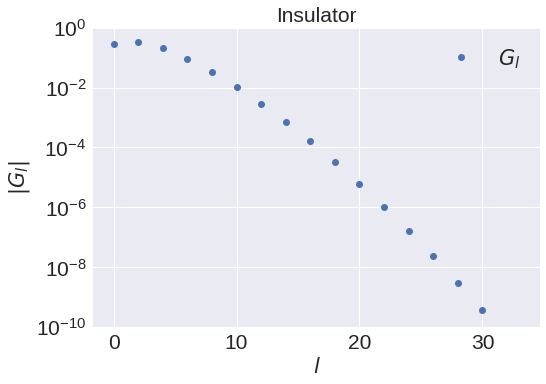

In [5]:
Sl = numpy.sqrt(0.5 * beta * wmax) * numpy.array([basis.sl(l) for l in range(dim)])
gl = - Sl * rho_l
plt.semilogy(numpy.abs(gl), marker="o", ls='', label=r"$G_l$")
plt.title(model, fontsize = 21)
plt.ylabel(r"$|G_l|$", fontsize = 21)
plt.tick_params(labelsize=21)
plt.xlabel(r'$l$', fontsize = 21)
plt.ylim([1e-10,1])
plt.legend(frameon=False, fontsize = 21)

# Computing $G(\tau)$ from $G_l$

We compute the Matsubara Green's function $G(\tau)$ using
$$
G(\tau) = \sum_l G_l U_l(\tau)
$$
$$
U_l(\tau) = \sqrt{ \frac{2}{\beta}}u_l(\frac{2\tau}{\beta}-1)
$$

-0.499999999995928 -0.499999999995928


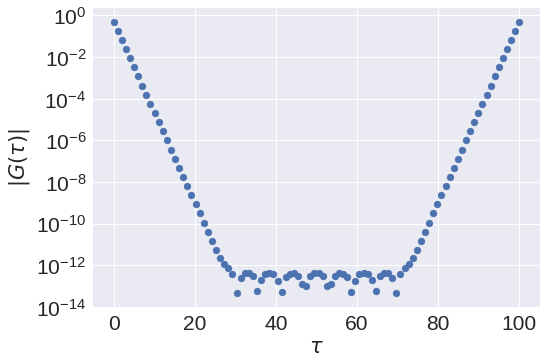

In [6]:
n_tau = 100
taus = numpy.linspace(0, beta, n_tau)
xs = numpy.linspace(-1, 1, n_tau)

ulx = numpy.array([basis.ulx(l, x) for x in xs for l in range(dim)]).reshape((n_tau, dim))
Ultau = numpy.sqrt(2/beta)*ulx

goftau = numpy.dot(Ultau, gl)

plt.yscale("log")

plt.ylabel(r"$|G(\tau)|$",fontsize=21)
plt.tick_params(labelsize=21)
plt.xlabel(r'$\tau$',fontsize = 21)

plt.scatter(taus, numpy.abs(goftau), marker="o")
print(goftau[0], goftau[-1])

# Computing $G(i\omega_n)$ from $G_l$


$$
G(i\omega_n) = \sum_l U_l({i\omega_n})G_l = \sum_l \sqrt{\beta}u_{nl}G_l
$$

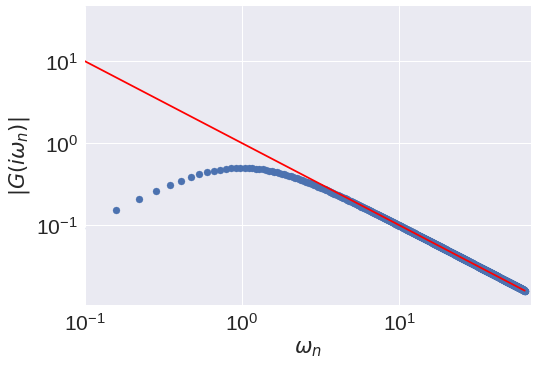

In [15]:
n_iw = 1000
ns = numpy.arange(n_iw)
wn = (2 * ns + 1) * numpy.pi/beta
Unl = numpy.sqrt(beta) * basis.compute_unl(ns)
Giw = numpy.dot(Unl, gl)

plt.xscale("log")
plt.yscale("log")
plt.xlim(0.1,wn[-1]*1.1)

plt.ylabel(r"$|G(i\omega_n)|$",fontsize=21)
plt.xlabel(r'$\omega_n$',fontsize = 21)

plt.tick_params(labelsize=21)
plt.scatter(wn,numpy.abs(Giw), marker="o")
plt.plot(wn, 1/wn, linestyle='-',c="r")

# Compute $G_l$ by least squares fitting

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # This is added back by InteractiveShellApp.init_path()


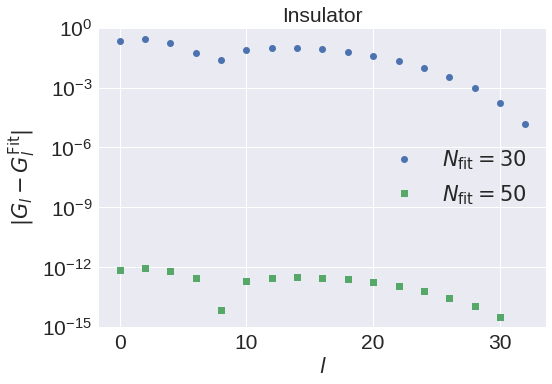

In [8]:
markers = ['o', 's']
i = 0
for Nfit in [30, 50]:
    # Evaluate G(tau) on a uniform mesh
    x_mesh = numpy.linspace(-1, 1, Nfit)
    ulx = numpy.array([basis.ulx(l, x) for x in x_mesh for l in range(dim)]).reshape((Nfit, dim))
    Ultau = numpy.sqrt(2/beta)*ulx
    goftau = numpy.dot(Ultau, gl)
    
    # Least squares fitting
    r = numpy.linalg.lstsq(Ultau, goftau)
    gl_fit = r[0]
    
    # We plot data for even l
    plt.semilogy(numpy.arange(0,dim,2), numpy.abs(gl-gl_fit)[::2],
                 marker=markers[i], ls='', label=r"$N_\mathrm{{fit}}={}$".format(Nfit))
    
    i += 1

plt.title(model, fontsize = 21)
plt.ylabel(r"$|G_l - G_l^\mathrm{Fit}|$", fontsize = 21)
plt.tick_params(labelsize=21)
plt.xlabel(r'$l$', fontsize = 21)
plt.ylim([1e-15,1])
plt.legend(frameon=False, fontsize = 21)